# **NASA: Asteroids Classification**

## Introduction
### Dataset

The data used for this project was obtained from the NASA: Asteroids Classification page on Kaggle (https://www.kaggle.com/datasets/lovishbansal123/nasa-asteroids-classification/data). It consists of 4688 instances, each with 40 columns. These columns include information such as the NEO reference ID, name, absolute magnitude, estimated diameter in kilometers (min/max), estimated diameter in meters (min/max), estimated diameter in miles (min/max), estimated diameter in feet (min/max), close approach date, epoch date of close approach, relative velocity in kilometers per second and hour, miles per hour, the miss distance in astronomical units, lunar distance, kilometers, and miles, the orbiting body, orbit ID, orbit determination date, orbit uncertainty, minimum orbit intersection, Jupiter Tisserand invariant, epoch osculation, eccentricity, semi-major axis, inclination, ascending node longitude, orbital period, perihelion distance, perihelion arg, aphelion distance, perihelion time, mean anomaly, mean motion, equinox, and hazardous.

### Problem and Objective

The goal of this project is to identify hazardous and non-hazardous asteroids based on the 40 attributes referred above. 

### Solution

To solve this problem, we will use a learning model that will be trained using the aforementioned database. The model will be divided into two sets, namely the training set and the test set. Using accuracy metrics, we will determine the percentage of correct predictions made by the model. 

### Installing Libraries

We will start by instaling the necessary libraries for this project.
To install the libraries, use the following commands:

```shell
sh ./requirements.sh
```
This shell script will install the necessary libraries for this project. To use it, you must have the `pip` package manager installed on your machine.

Also, if you are using Windows, and you don't have `bash` installed, you should install it before running the script (we suggest using Git Bash, or WSL).

### Importing Libraries

Now, let's import the libraries that we will use in this project:


In [62]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math
import time

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_curve, auc,
                             precision_recall_curve, average_precision_score, ConfusionMatrixDisplay,
                             precision_score, f1_score, recall_score)
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier


warnings.filterwarnings("ignore")

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    return {
        "precision": precision_score(y_true, y_pred, average='weighted'),
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average='weighted'),
        "recall": recall_score(y_true, y_pred, average='weighted')
    }

# Train and evaluate model
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    
    start_test = time.time()
    y_pred = model.predict(X_test)
    end_test = time.time()
    
    metrics = calculate_metrics(y_test, y_pred)
    return {
        "train_time": end_train - start_train,
        "test_time": end_test - start_test,
        **metrics
    }


## Data Pre-processing

### Creating a dataframe with the original dataset

In [63]:
DATA_FILE = 'nasa_db.csv'

data = pd.read_csv(DATA_FILE)

data.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


### Pre-analysis
Before starting the analysis and do any data manipulation, its importante take a look at the dataset to understand the data, such as missing or null values and filter out any outliers.

In [64]:
data.describe()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion
count,4.687000e+03,4.687000e+03,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,...,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4.687000e+03,4687.000000,4687.000000
mean,3.272298e+06,3.272298e+06,22.267865,0.204604,0.457509,204.604203,457.508906,0.127135,0.284283,671.273653,...,1.400264,13.373844,172.157275,635.582076,0.813383,183.932151,1.987144,2.457728e+06,181.167927,0.738242
std,5.486011e+05,5.486011e+05,2.890972,0.369573,0.826391,369.573402,826.391249,0.229642,0.513496,1212.511199,...,0.524154,10.936227,103.276777,370.954727,0.242059,103.513035,0.951519,9.442264e+02,107.501623,0.342627
min,2.000433e+06,2.000433e+06,11.160000,0.001011,0.002260,1.010543,2.259644,0.000628,0.001404,3.315431,...,0.615920,0.014513,0.001941,176.557161,0.080744,0.006918,0.803765,2.450100e+06,0.003191,0.086285
25%,3.097594e+06,3.097594e+06,20.100000,0.033462,0.074824,33.462237,74.823838,0.020792,0.046493,109.784247,...,1.000635,4.962341,83.081208,365.605031,0.630834,95.625916,1.266059,2.457815e+06,87.006918,0.453289
50%,3.514799e+06,3.514799e+06,21.900000,0.110804,0.247765,110.803882,247.765013,0.068850,0.153954,363.529809,...,1.240981,10.311836,172.625393,504.947292,0.833153,189.761641,1.618195,2.457973e+06,185.718889,0.712946
75%,3.690060e+06,3.690060e+06,24.500000,0.253837,0.567597,253.837029,567.596853,0.157727,0.352688,832.798679,...,1.678364,19.511681,255.026909,794.195972,0.997227,271.777557,2.451171,2.458108e+06,276.531946,0.984669
max,3.781897e+06,3.781897e+06,32.100000,15.579552,34.836938,15579.552413,34836.938254,9.680682,21.646663,51114.018738,...,5.072008,75.406667,359.905890,4172.231343,1.299832,359.993098,8.983852,2.458839e+06,359.917991,2.039000


In [65]:
data.isna().any()

Neo Reference ID                False
Name                            False
Absolute Magnitude              False
Est Dia in KM(min)              False
Est Dia in KM(max)              False
Est Dia in M(min)               False
Est Dia in M(max)               False
Est Dia in Miles(min)           False
Est Dia in Miles(max)           False
Est Dia in Feet(min)            False
Est Dia in Feet(max)            False
Close Approach Date             False
Epoch Date Close Approach       False
Relative Velocity km per sec    False
Relative Velocity km per hr     False
Miles per hour                  False
Miss Dist.(Astronomical)        False
Miss Dist.(lunar)               False
Miss Dist.(kilometers)          False
Miss Dist.(miles)               False
Orbiting Body                   False
Orbit ID                        False
Orbit Determination Date        False
Orbit Uncertainity              False
Minimum Orbit Intersection      False
Jupiter Tisserand Invariant     False
Epoch Oscula

### Cleaning and preparing dataset
The dataset has no missing values, however, there are some columns that are not relevant for the analysis, as they show the same information under different measures that can be converted to each other, sucha as `Est Dia`, `Relative Velocity`, `Miss Dist.`. Therefore, we will remove these columns.
We decide keep the Km measure and remove the others.
x

From the analysis above, we see that there are also unecessary columns that irrelevant for the analysis. For example, `Orbit Body` and `Equinox` have the same value for all the instances, as we can see bellow. Therefore, we will remove these columns from the dataset.

In [66]:
count_values = data.groupby('Orbiting Body').size().reset_index(name='count')
print(count_values)
count_values = data.groupby('Equinox').size().reset_index(name='count')
print(count_values)

data = data.drop(['Orbiting Body'], axis=1)
data = data.drop(['Equinox'], axis=1)
data = data.drop(['Name'], axis=1)
data = data.drop(['Est Dia in M(min)'], axis=1)
data = data.drop(['Est Dia in M(max)'], axis=1)
data = data.drop(['Est Dia in Miles(min)'], axis=1)
data = data.drop(['Est Dia in Miles(max)'], axis=1)
data = data.drop(['Est Dia in Feet(min)'], axis=1)
data = data.drop(['Est Dia in Feet(max)'], axis=1)
data = data.drop(['Relative Velocity km per sec'], axis=1)
data = data.drop(['Miles per hour'], axis=1)
data = data.drop(['Miss Dist.(Astronomical)'], axis=1)
data = data.drop(['Miss Dist.(lunar)'], axis=1)
data = data.drop(['Miss Dist.(miles)'], axis=1)
data = data.drop(['Close Approach Date'],axis=1)
data = data.drop(['Orbit Determination Date'],axis=1)

data.head()

  Orbiting Body  count
0         Earth   4687
  Equinox  count
0   J2000   4687


,Neo Reference ID,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Epoch Date Close Approach,Relative Velocity km per hr,Miss Dist.(kilometers),Orbit ID,Orbit Uncertainity,Minimum Orbit Intersection,...,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
0,3703080,21.6,0.127220,0.284472,788947200000,22017.003799,62753692.0,17,5,0.025282,...,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,True
1,3723955,21.3,0.146068,0.326618,788947200000,65210.346095,57298148.0,21,3,0.186935,...,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,False
2,2446862,20.3,0.231502,0.517654,789552000000,27326.560182,7622911.5,22,0,0.043058,...,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,True
3,3092506,27.4,0.008801,0.019681,790156800000,40225.948191,42683616.0,7,6,0.005512,...,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,False
4,3514799,21.6,0.127220,0.284472,790156800000,35426.991794,61010824.0,25,1,0.034798,...,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,True


The target variable is a categorical variable, so we will encode it to numerical values in order to use it in the model. 
The other variables are already numerical, so we don't need to encode them.

In [67]:
encoder = LabelEncoder()

data['Hazardous'] = encoder.fit_transform(data['Hazardous'])

data.head()


,Neo Reference ID,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Epoch Date Close Approach,Relative Velocity km per hr,Miss Dist.(kilometers),Orbit ID,Orbit Uncertainity,Minimum Orbit Intersection,...,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
0,3703080,21.6,0.127220,0.284472,788947200000,22017.003799,62753692.0,17,5,0.025282,...,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,1
1,3723955,21.3,0.146068,0.326618,788947200000,65210.346095,57298148.0,21,3,0.186935,...,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,0
2,2446862,20.3,0.231502,0.517654,789552000000,27326.560182,7622911.5,22,0,0.043058,...,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,1
3,3092506,27.4,0.008801,0.019681,790156800000,40225.948191,42683616.0,7,6,0.005512,...,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,0
4,3514799,21.6,0.127220,0.284472,790156800000,35426.991794,61010824.0,25,1,0.034798,...,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,1


### Analysis
Since the dataset is already clean, we will proceed to the analysis of the data, to get some insights and understand it better.

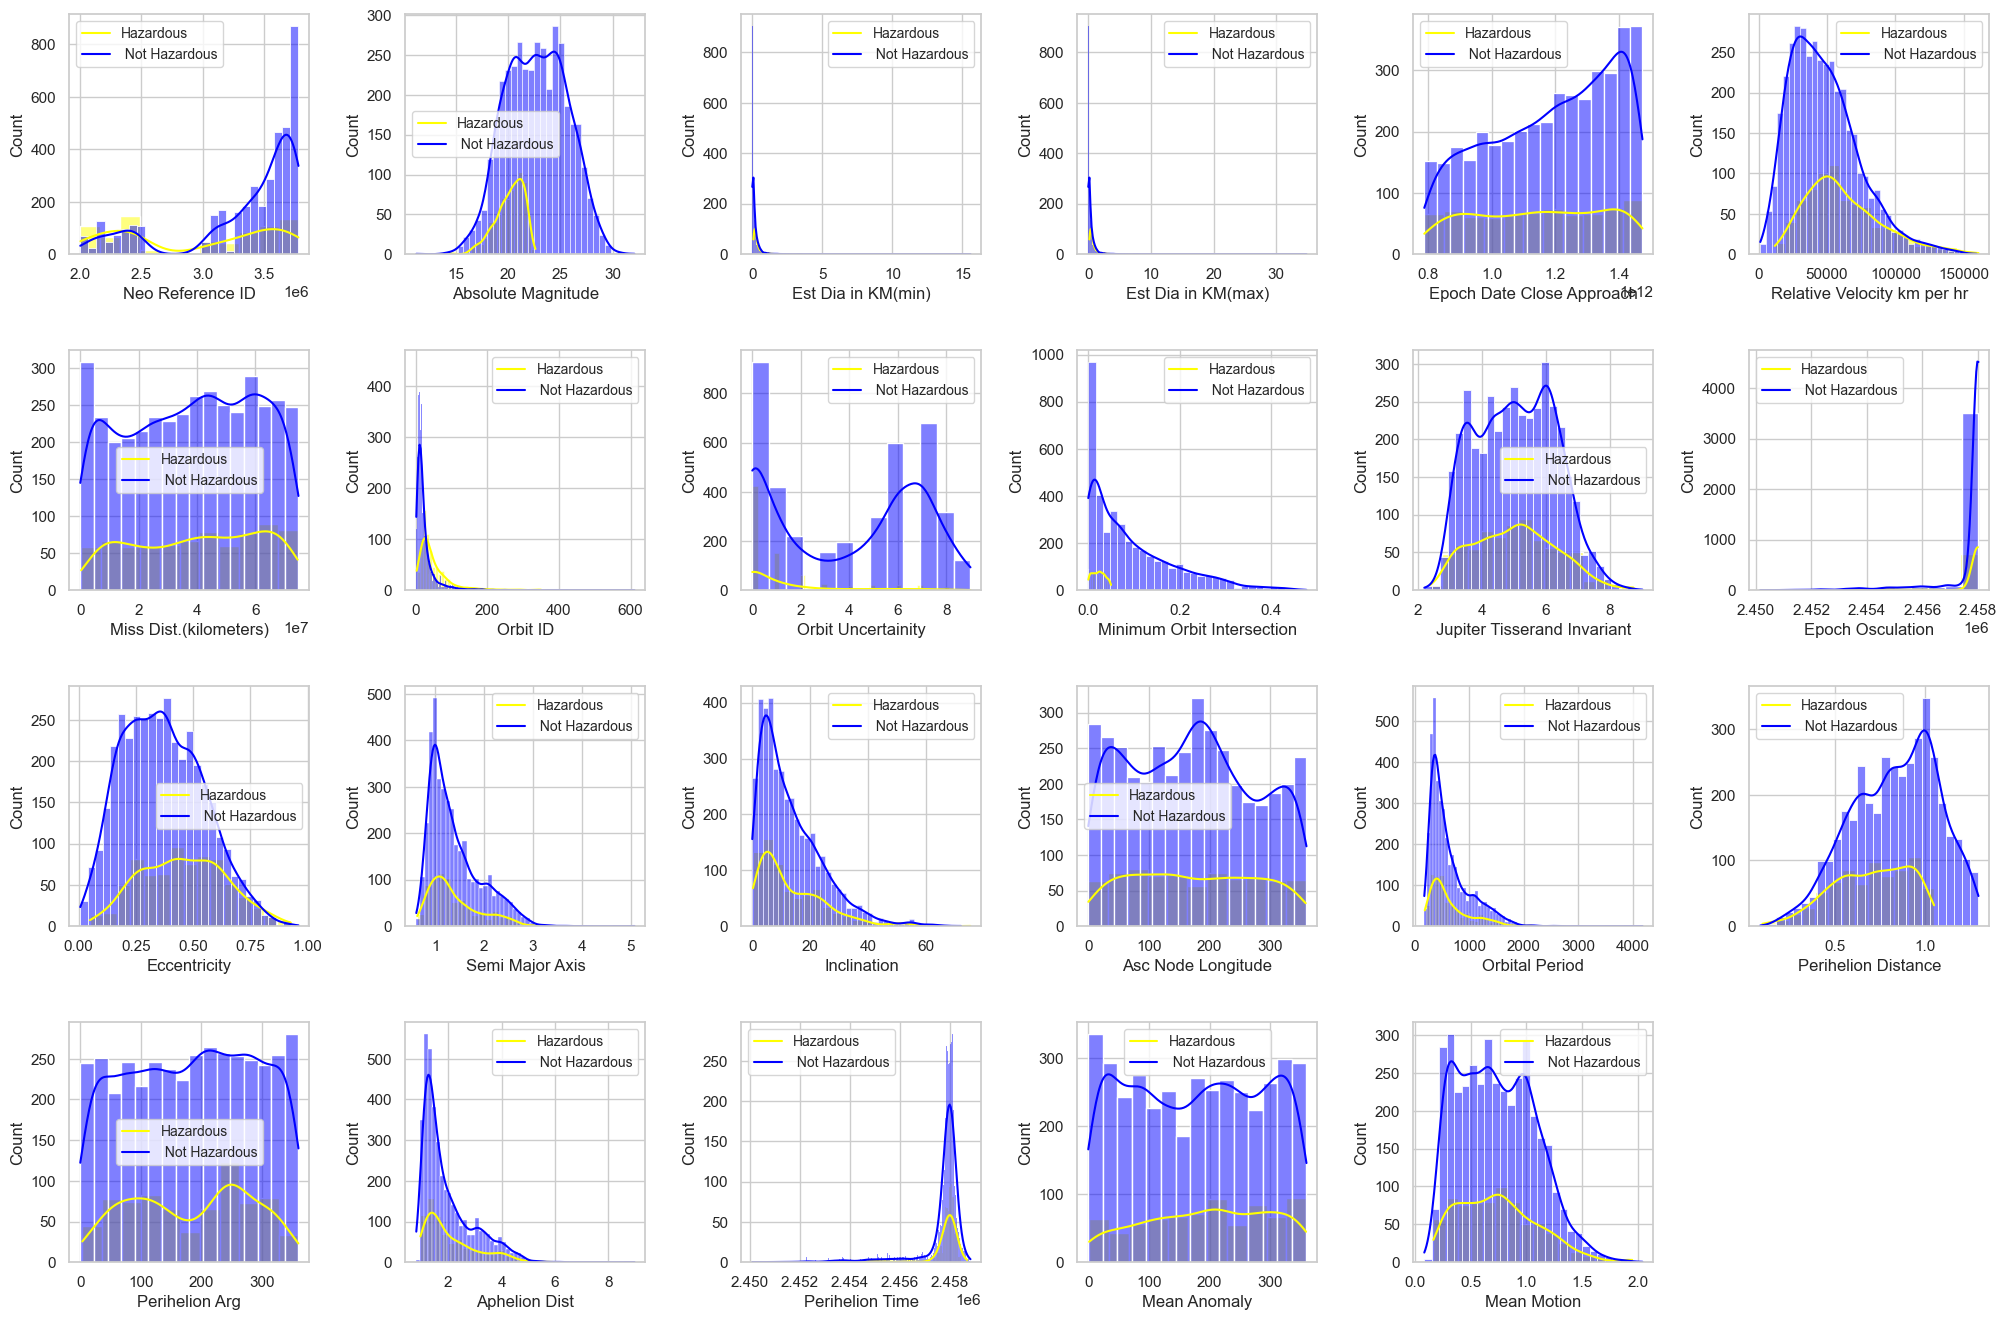

In [68]:
plt.figure(figsize=(24,24))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

data1 = data[data['Hazardous']==1].drop(['Hazardous'],axis=1)
data2 = data[data['Hazardous']==0].drop(['Hazardous'],axis=1)

cols = list(data1.columns)

for i, col in enumerate(cols):
   
    plt.subplot(6,6,i+1)
    sb.histplot(data=data1[col], color='yellow', label = 'Hazardous', kde=True)
    sb.histplot(data=data2[col], color='blue', label = ' Not Hazardous', kde=True)
    _,axes = plt.gca().get_legend_handles_labels()
    plt.legend(axes,prop={'size': 10})

plt.show()

After that, we can see the plot of the correlation matrix, which shows the correlation between the variables.

<Axes: >

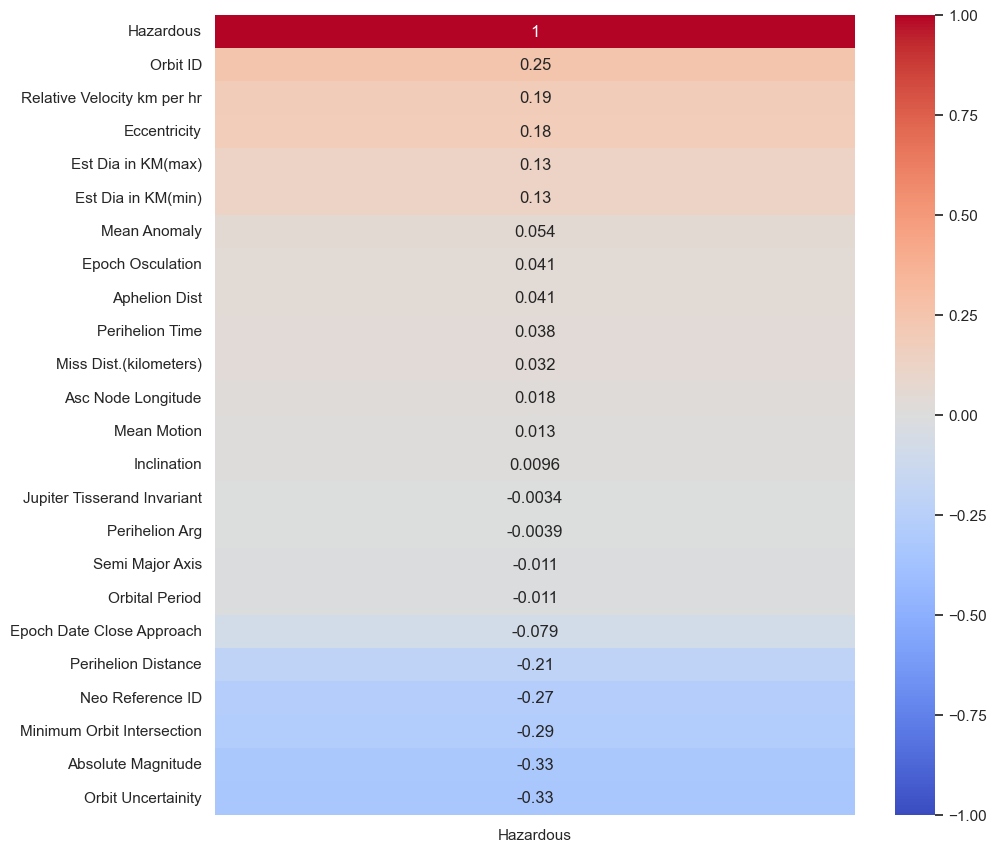

In [69]:
cols = list(data1.columns)

plt.figure(figsize=(10,10))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

corr = data.corr()[['Hazardous']].sort_values(by='Hazardous', ascending=False)
sb.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

As we can see from the correlation matrix, the variables are not highly correlated with each other. 

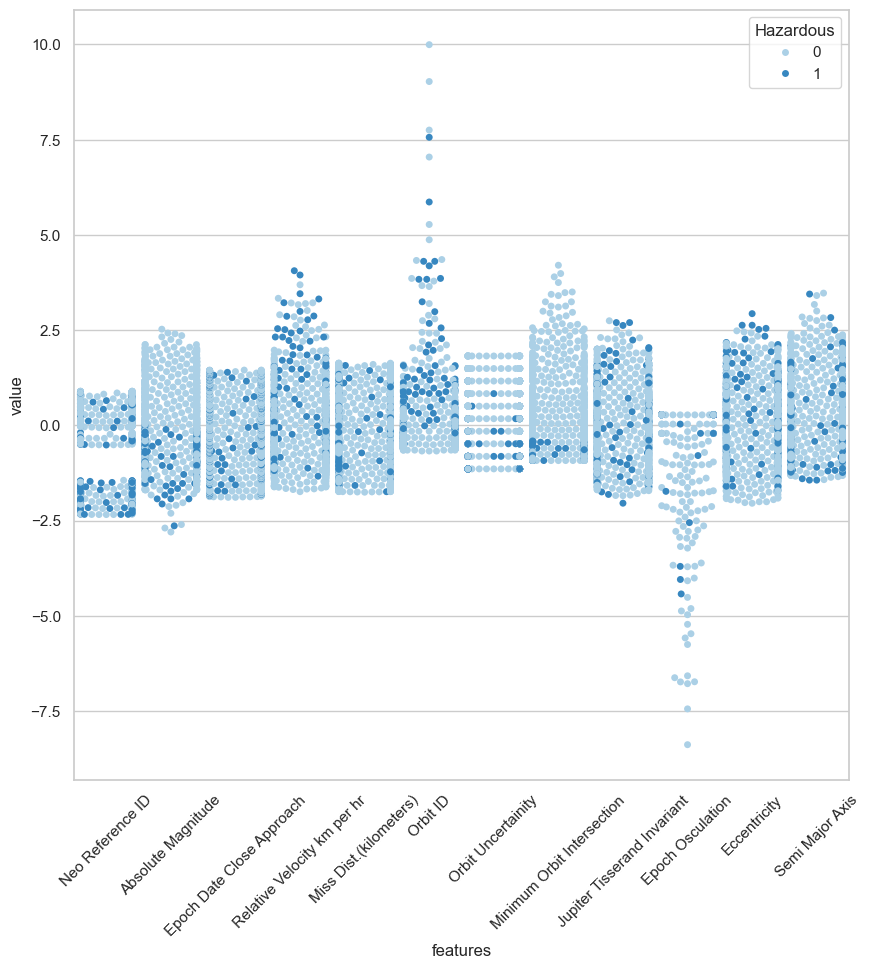

,Neo Reference ID,Absolute Magnitude,Epoch Date Close Approach,Relative Velocity km per hr,Miss Dist.(kilometers),Orbit ID,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,...,Inclination,Asc Node Longitude,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous,Est Dia in KM(mean)
3804,2490581,20.4,1389772800000,27511.494115,20335124.0,56,1,0.031146,6.867,2458000.5,...,9.834618,263.277974,0.690580,10.534391,1.020137,2.457943e+06,71.979993,1.245895,1,0.357720
4680,3608620,23.6,1473318000000,49274.492882,49683940.0,8,7,0.086149,5.954,2458000.5,...,24.775334,175.870458,0.883224,320.137043,1.133252,2.458175e+06,189.698962,0.973552,0,0.081949
805,3028805,20.8,949996800000,31567.851992,6903757.5,33,0,0.044154,4.884,2458000.5,...,11.550807,132.861704,0.962833,50.205066,1.682761,2.457731e+06,174.511462,0.647835,1,0.297538
3996,3690058,25.3,1410764400000,23112.637369,14563527.0,6,8,0.095969,3.221,2456922.5,...,4.593513,0.202437,1.100599,355.439742,3.913323,2.456918e+06,1.065513,0.248303,0,0.037458
3523,3623679,23.4,1356163200000,33930.248846,21011558.0,8,6,0.140935,4.367,2458000.5,...,13.746344,294.603964,0.999165,110.878970,2.082354,2.458338e+06,186.073353,0.515349,0,0.089855


In [80]:
sb.set(style='whitegrid')
sample_size = 1000
data_sample = data
if len(data) > sample_size:
    data_sample = data.sample(n=sample_size, random_state=42)
data_std = (data_sample - data_sample.mean()) / data_sample.std()
data_temp = pd.concat([data['Hazardous'], data_std.iloc[:,0:12]], axis=1)
data_temp = pd.melt(data_temp, id_vars='Hazardous', var_name='features', value_name='value')
plt.figure(figsize=(10,10))
sb.swarmplot(x='features', y='value', hue='Hazardous', data=data_temp, palette='Blues')
plt.xticks(rotation=45)
plt.show()
data_sample.head()

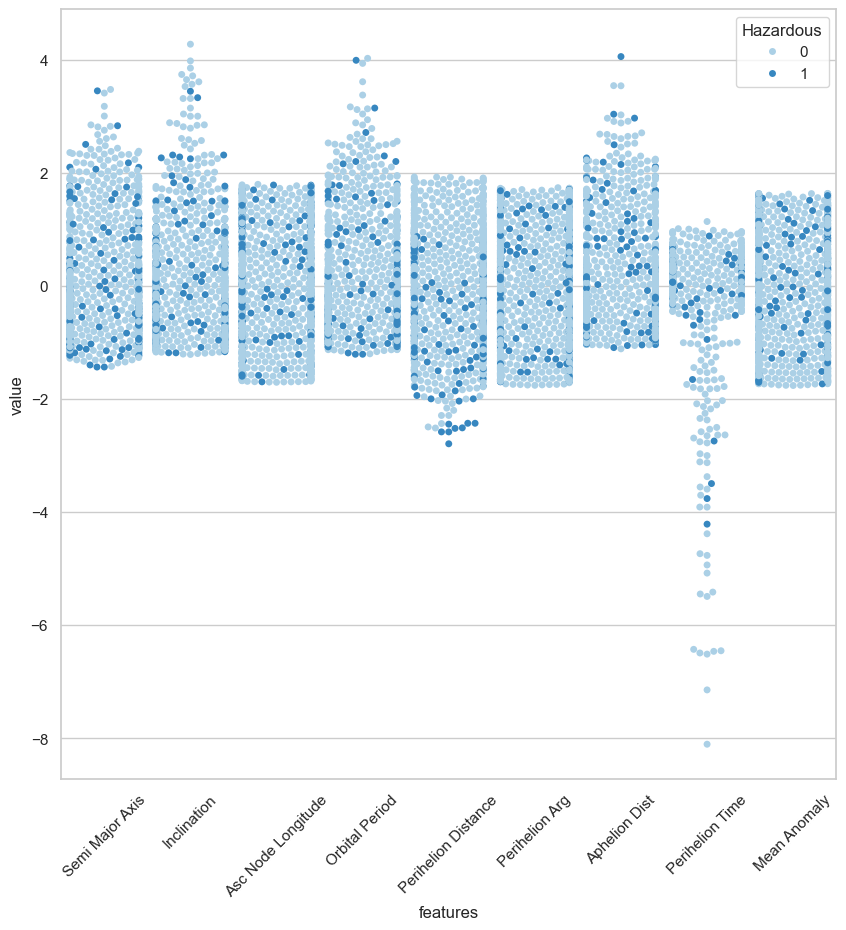

,Neo Reference ID,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Epoch Date Close Approach,Relative Velocity km per hr,Miss Dist.(kilometers),Orbit ID,Orbit Uncertainity,Minimum Orbit Intersection,...,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
3804,2490581,20.4,0.221083,0.494356,1389772800000,27511.494115,20335124.0,56,1,0.031146,...,9.834618,263.277974,288.948855,0.690580,10.534391,1.020137,2.457943e+06,71.979993,1.245895,1
4680,3608620,23.6,0.050647,0.113250,1473318000000,49274.492882,49683940.0,8,7,0.086149,...,24.775334,175.870458,369.779900,0.883224,320.137043,1.133252,2.458175e+06,189.698962,0.973552,0
805,3028805,20.8,0.183889,0.411188,949996800000,31567.851992,6903757.5,33,0,0.044154,...,11.550807,132.861704,555.697196,0.962833,50.205066,1.682761,2.457731e+06,174.511462,0.647835,1
3996,3690058,25.3,0.023150,0.051765,1410764400000,23112.637369,14563527.0,6,8,0.095969,...,4.593513,0.202437,1449.839167,1.100599,355.439742,3.913323,2.456918e+06,1.065513,0.248303,0
3523,3623679,23.4,0.055533,0.124177,1356163200000,33930.248846,21011558.0,8,6,0.140935,...,13.746344,294.603964,698.555256,0.999165,110.878970,2.082354,2.458338e+06,186.073353,0.515349,0


In [70]:
sb.set(style='whitegrid')
sample_size = 1000
data_sample = data
if len(data) > sample_size:
    data_sample = data.sample(n=sample_size, random_state=42)
data_std = (data_sample - data_sample.mean()) / data_sample.std()
data_temp = pd.concat([data['Hazardous'], data_std.iloc[:,13:22]], axis=1)
data_temp = pd.melt(data_temp, id_vars='Hazardous', var_name='features', value_name='value')
plt.figure(figsize=(10,10))
sb.swarmplot(x='features', y='value', hue='Hazardous', data=data_temp, palette='Blues')
plt.xticks(rotation=45)
plt.show()
data_sample.head()

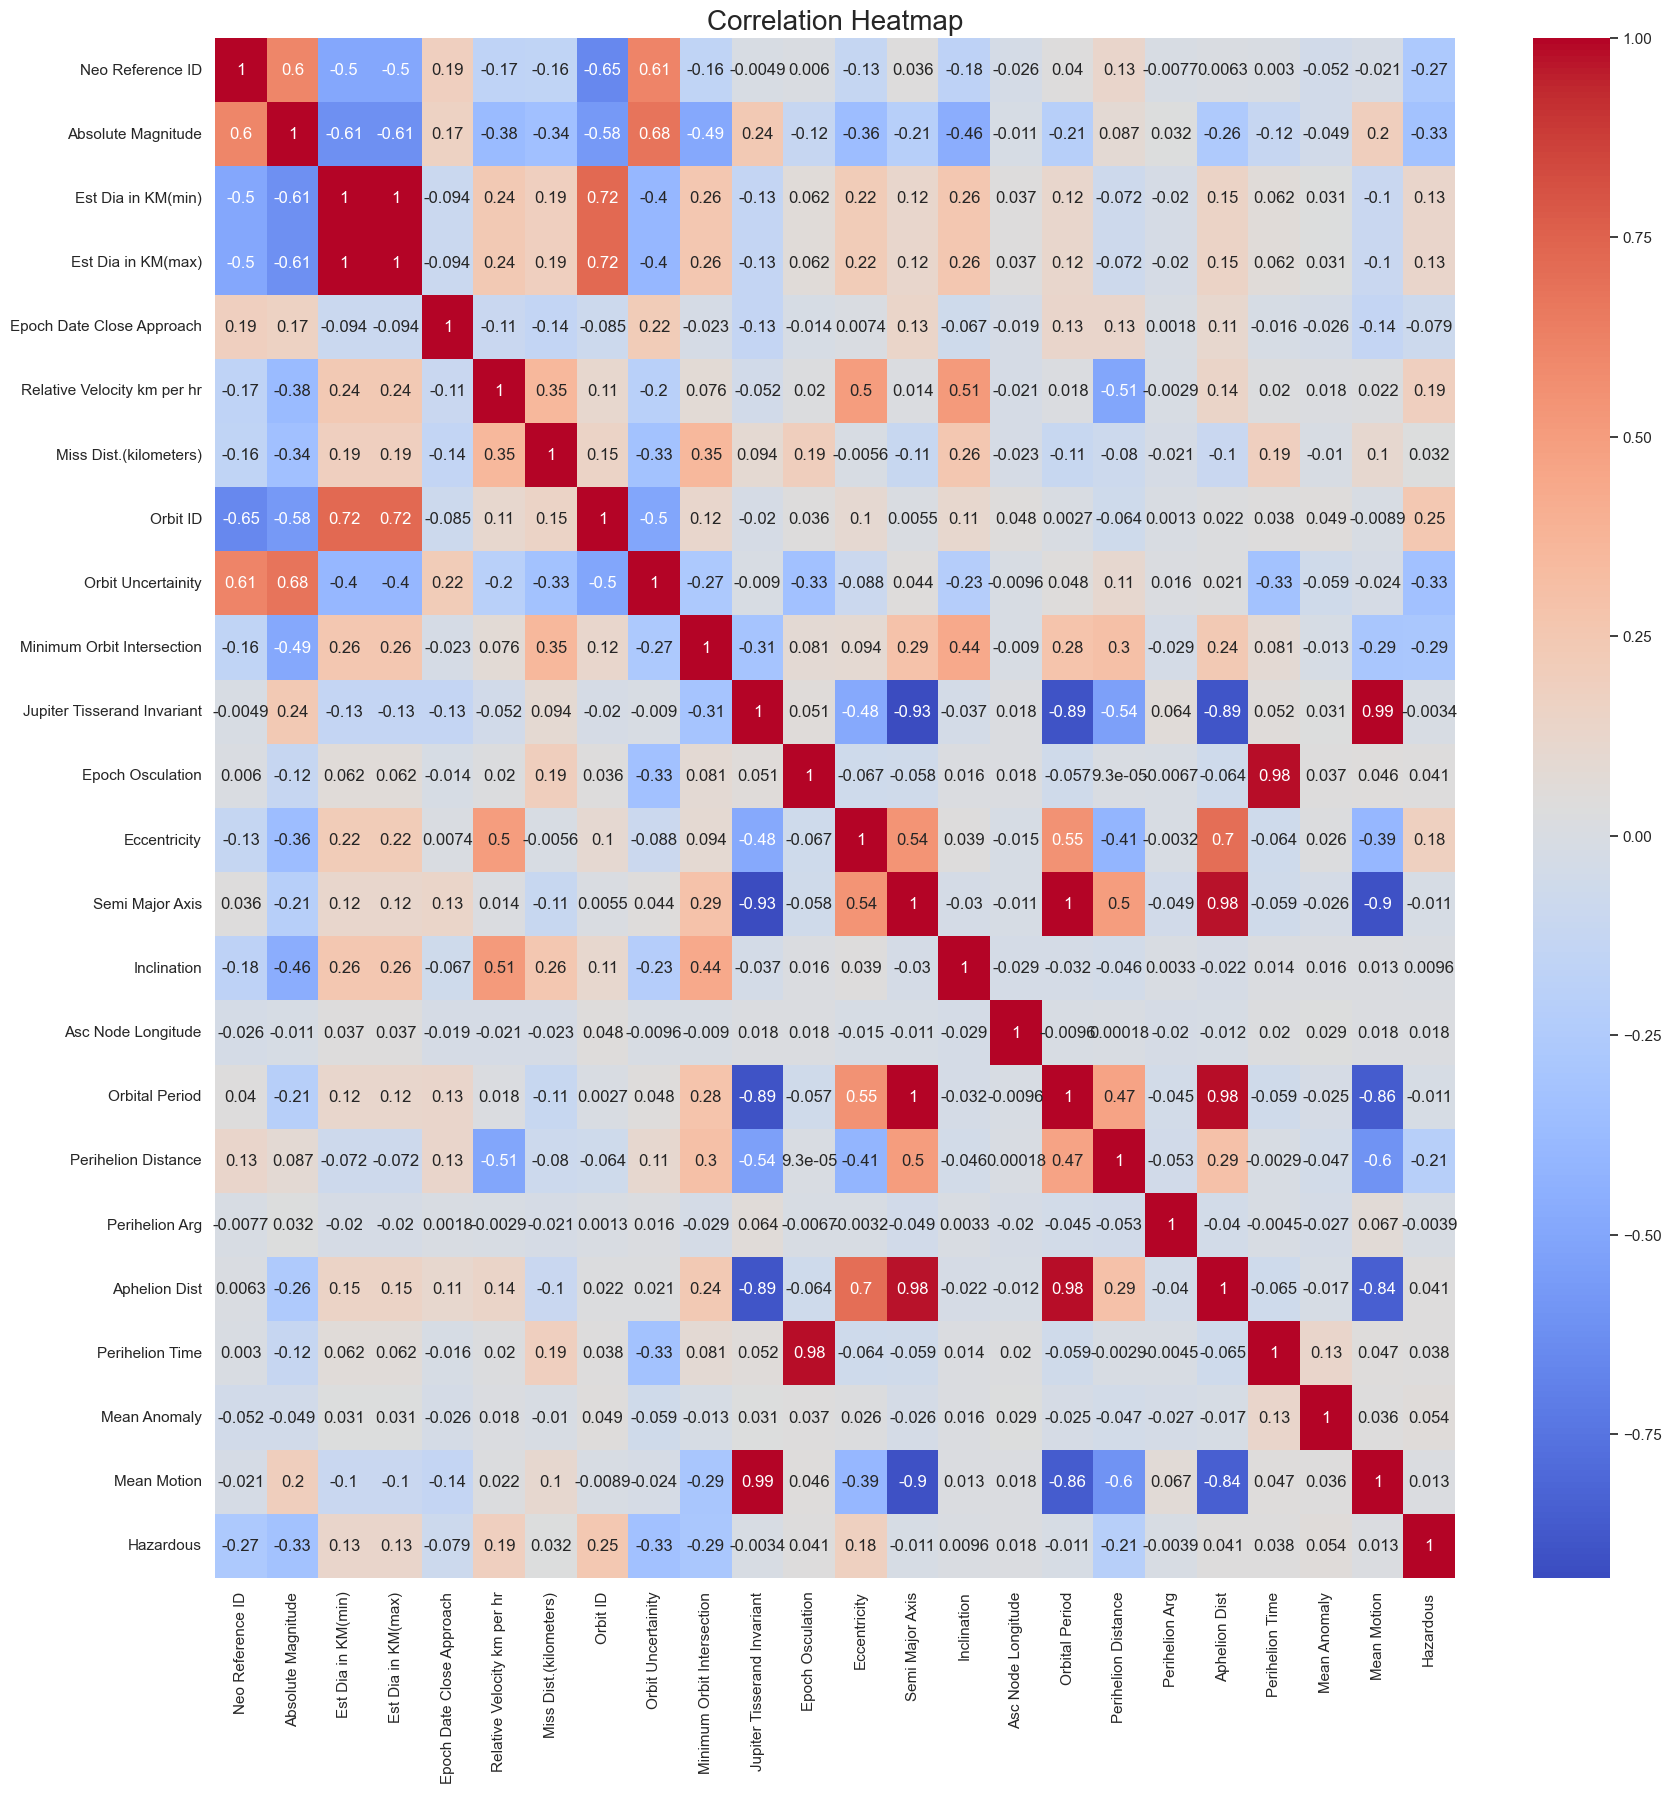

In [71]:
plt.figure(figsize=(20,20))
sb.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap', fontsize=20)
plt.show()

In [72]:
data['Est Dia in KM(mean)'] = data[['Est Dia in KM(max)', 'Est Dia in KM(min)']].mean(axis=1)

data = data.drop(['Est Dia in KM(max)', 'Est Dia in KM(min)'], axis=1)
data.head()

,Neo Reference ID,Absolute Magnitude,Epoch Date Close Approach,Relative Velocity km per hr,Miss Dist.(kilometers),Orbit ID,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous,Est Dia in KM(mean)
0,3703080,21.6,788947200000,22017.003799,62753692.0,17,5,0.025282,4.634,2458000.5,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,1,0.205846
1,3723955,21.3,788947200000,65210.346095,57298148.0,21,3,0.186935,5.457,2458000.5,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,0,0.236343
2,2446862,20.3,789552000000,27326.560182,7622911.5,22,0,0.043058,4.557,2458000.5,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,1,0.374578
3,3092506,27.4,790156800000,40225.948191,42683616.0,7,6,0.005512,5.093,2458000.5,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,0,0.014241
4,3514799,21.6,790156800000,35426.991794,61010824.0,25,1,0.034798,5.154,2458000.5,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,1,0.205846


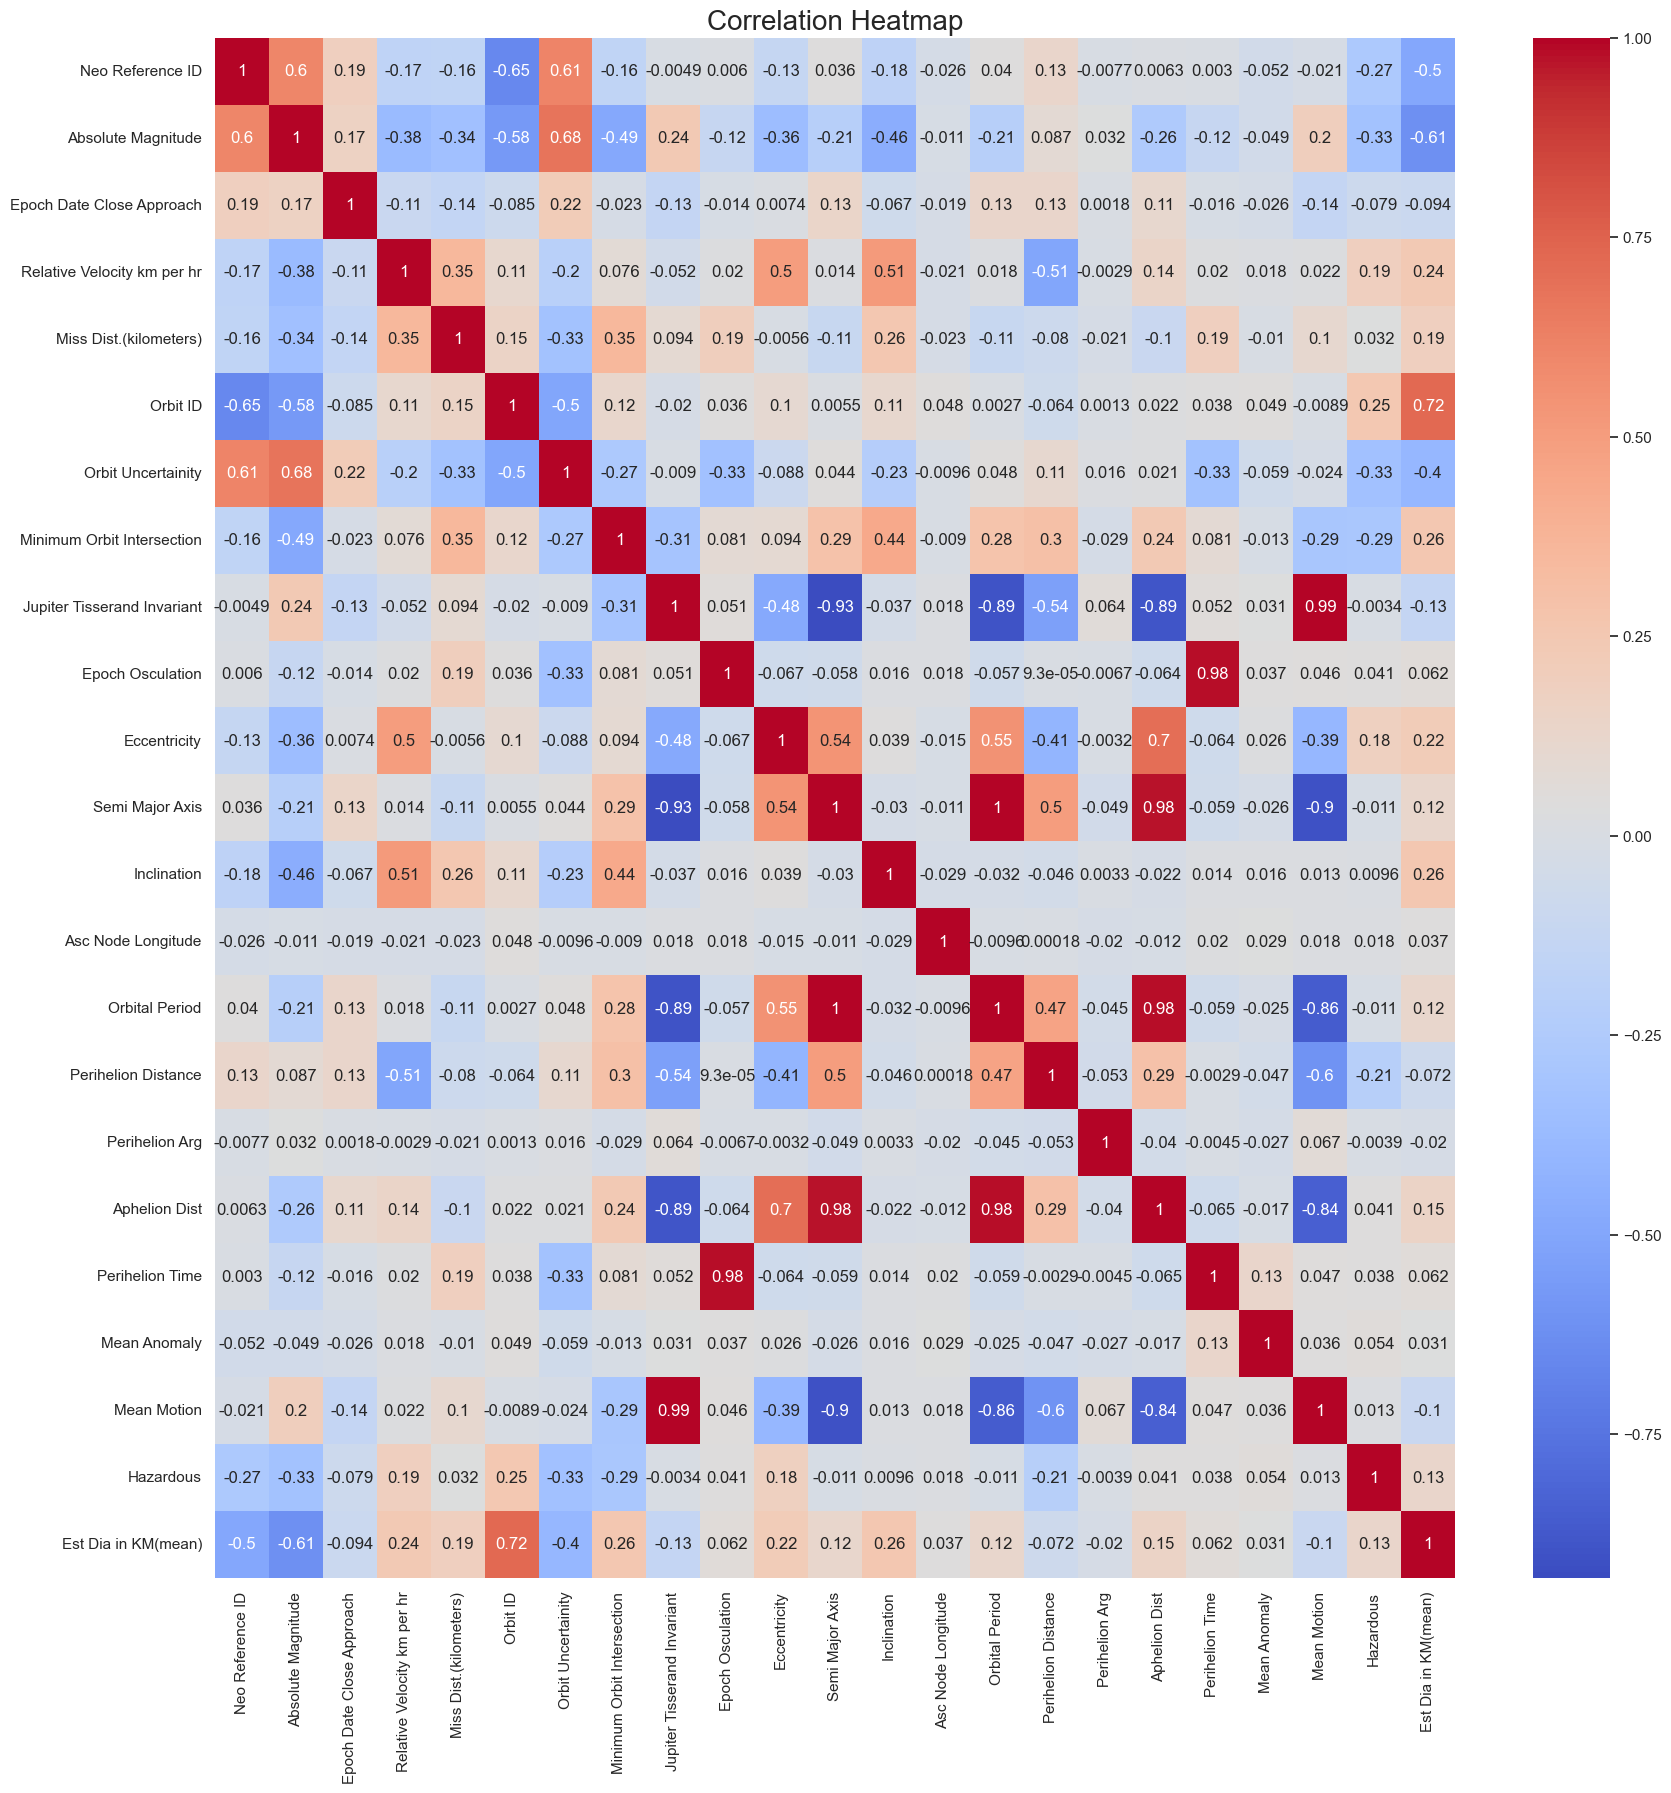

In [73]:
plt.figure(figsize=(20,20))
sb.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap', fontsize=20)
plt.show()

As we can see, `Semi Major Axis` and `Orbit ID` have a high correlation between them. This can be explained by Kepler's third law that states that the square of a planet's orbital period is proportional to the cube of the semi-major axis of its orbit. So, we will remove one of them to avoid multicollinearity.

In [74]:
data = data.drop(['Orbital Period'], axis=1)


# Model Training

## Prepare the data

As we can see from the analysis above, the dataset is unbalanced, with major of the asteroids being non-hazardous. This can be a problem when training the model, as it can be biased to predict that all asteroids are non-hazardous. So, for this project, we will balance the dataset using the SMOTE technique, and compare the results achieved with and without balancing the dataset.

In [75]:
all_inputs = data.drop(['Hazardous'], axis=1).values
all_labels = data['Hazardous'].values
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=1)

smote = SMOTE(random_state=42)
training_inputs_bal, training_classes_bal = smote.fit_resample(training_inputs, training_classes)

For better visualization of the results, we will use a dictionary to store the results of the models and other to keep the models.
The algorithms that we will use are:
- Decision Trees
- Random Forest
- Neural Networks
- K-NN
- SVM
- Gradient Boosting Algorithms (CatBoost)
- Logistic Regression
- Naive Bayes

In [76]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
    "K-NN": KNeighborsClassifier(),
    "SVM": SVC(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB()
}

results = {
    "unbalanced": {},
    "balanced": {}
}

### Algorithms employment
The results of the models will be store in the `results` dictionary, where the attributes that we will use to compare them are the following:
- time to train the model 
- time to test the model  
- precision Score  
- accuracy Score 
- d1 Score 
- recall Score.

In [77]:
# Training and evaluating the models on the unbalanced dataset
for model_name, model in models.items():
    results["unbalanced"][model_name] = train_and_evaluate(model, training_inputs, testing_inputs, training_classes,
 testing_classes)

# Training and evaluating the models on the unbalanced dataset
for model_name, model in models.items():
    results["balanced"][model_name] = train_and_evaluate(model, training_inputs_bal, testing_inputs, training_classes_bal, testing_classes)


## Algorithm comparison

In [78]:
print("============================= UNBALANCED DATASET RESUTS =============================")
("\n")
results_unbalanced = pd.DataFrame(results["unbalanced"])
print(results_unbalanced)


============================= UNBALANCED DATASET RESUTS =============================
            Decision Tree  Random Forest  Neural Network      K-NN       SVM  \
train_time       0.032453       1.084723        1.623271  0.000000  0.349858   
test_time        0.000000       0.016674        0.000000  0.016659  0.308815   
precision        0.993174       0.995745        0.683585  0.711505  0.683585   
accuracy         0.993174       0.995734        0.826792  0.798635  0.826792   
f1               0.993174       0.995738        0.748399  0.744518  0.748399   
recall           0.993174       0.995734        0.826792  0.798635  0.826792   

            CatBoost  Logistic Regression  Naive Bayes  
train_time  7.990851             0.078160     0.000000  
test_time   0.015580             0.000000     0.000000  
precision   0.995745             0.683585     0.683585  
accuracy    0.995734             0.826792     0.826792  
f1          0.995738             0.748399     0.748399  
recall     

In [79]:
print("============================== BALANCED DATASET RESUTS ==============================")
("\n")
results_balanced = pd.DataFrame(results["balanced"])
print(results_balanced)

============================== BALANCED DATASET RESUTS ==============================
            Decision Tree  Random Forest  Neural Network      K-NN       SVM  \
train_time       0.031243       2.007349        1.164431  0.000000  3.319713   
test_time        0.000000       0.000000        0.000000  0.067051  1.662274   
precision        0.994910       0.995745        0.030001  0.731887  0.727872   
accuracy         0.994881       0.995734        0.173208  0.670648  0.632253   
f1               0.994890       0.995738        0.051144  0.696458  0.669384   
recall           0.994881       0.995734        0.173208  0.670648  0.632253   

             CatBoost  Logistic Regression  Naive Bayes  
train_time  13.332118             0.216898     0.000000  
test_time    0.015621             0.000000     0.016276  
precision    0.993266             0.778258     0.739490  
accuracy     0.993174             0.707338     0.572526  
f1           0.993200             0.733796     0.624259  
recal